In [ ]:
from __future__ import print_function
import argparse
import numpy as np
import os
import shutil
import time
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import pickle
from benedict import BeneDict
import copy
import seaborn as sns
from scipy.stats.stats import pearsonr
from scipy.stats import linregress
plt.style.use('seaborn-muted')
plt.style.use('seaborn-talk')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# Custom code
import utils as U
from generate_graph_structure import create_adjacency_matrix, flatten_correlation, granger_causality, behavioral_prediction_correlation_wrapper
from dataloading import read_from_files, filter_data, normalize_by_behavior_report_type

In [ ]:


savenames = ['BAYLORGC4_2018_03_22.mat', 
             'BAYLORGC4_2018_03_21.mat', 
             'BAYLORGC4_2018_03_23.mat', 
             'BAYLORGC4_2018_03_20.mat', 
             'BAYLORGC4_2018_03_25.mat', 
             'BAYLORGC12_2018_04_03.mat', 
             'BAYLORGC12_2018_04_04.mat',
             'BAYLORGC12_2018_04_05.mat', 'BAYLORGC12_2018_04_06.mat', 'BAYLORGC13_2018_04_23.mat', 'BAYLORGC13_2018_04_24.mat', 'BAYLORGC13_2018_04_25.mat', 'BAYLORGC15_2018_05_07.mat', 'BAYLORGC15_2018_05_08.mat', 'BAYLORGC15_2018_05_09.mat', 'BAYLORGC15_2018_05_10.mat', 'BAYLORGC15_2018_05_11.mat', 'BAYLORGC17_2018_06_08.mat', 'BAYLORGC17_2018_06_11.mat', 'BAYLORGC18_2018_05_31.mat', 'BAYLORGC19_2018_06_20.mat', 'BAYLORGC19_2018_06_21.mat', 'BAYLORGC19_2018_06_22.mat']
mice = [0, 5, 12, 17, 19, 20, 23]


# !!!!! Change here to generate graphs for different sessions
# all_file_to_read = [savenames[0]]
all_file_to_read = savenames
print('Reading files {}'.format(', '.join(all_file_to_read)))
all_data = read_from_files(all_file_to_read)

In [ ]:
# !!!!! Change here to generate graphs for different perturbation conditions

# The type of perturbation enforced
## 0: no 
## 1: perturbation of left
## 2: perturbation of right
## 3: perturbation of both

def binned(values, value_range):
    counts = np.array([0 for x in value_range])
    for value in values:
        for i in range(len(value_range)):
            if value > value_range[i]:
                counts[i] += 1
    counts = counts[:-1] - counts[1:]
    return counts

perturbation_type = 0 # or 1, 2, or 3
perturbation_type_names = ['No Perturbation', 'Left Perturbation', 'Right Perturbation', 'Bilateral Perturbation']
perturbation_type_name = perturbation_type_names[perturbation_type]

# Only look at success trials when True
# When there is bilarteral perturbation, the mice cannot act correctly, so we need to look at unsuccessful trials
enforce_task_success = (perturbation_type != 3)
# When there is no perturbation
if perturbation_type == 3:
    time_window = (22,37)
else:
# when there are perturbations, we use neural signals after the perturbations have ended
    time_window = (31,37)
    
## Filter all the data depending on what we want
all_data_filtered = [filter_data(data,
                                 perturbation_type=0,
                                 enforce_task_success=enforce_task_success,
                                 time_window=time_window) for data in all_data]



eps = 0.05
neuron_locations = all_data_filtered[0].neuron_locations
session_name = all_data_filtered[0].name
methods = [[flatten_correlation, granger_causality, behavioral_prediction_correlation_wrapper(all_data_filtered[i]['behavior_report_type'])] for i in range(23)]
mats = [[create_adjacency_matrix(all_data_filtered[i], edge_weight_func=x, perturbation_type=perturbation_type) for x in methods[i]] for i in range(23)]
method_names = ['Correlation', 'Causality', 'Behavioral Prediction Similarity']



In [ ]:
from sklearn.cluster import SpectralClustering

modularity = {}
modularity[0] = []
modularity[1] = []
modularity[2] = []

masks = {}
masks[0] = []
masks[1] = []
masks[2] = []

for j in range(len(mats)):
    print(j)
    mat = mats[j]
    neuron_locations = all_data_filtered[j].neuron_locations
    for i in range(3):
        try:
            A = np.array(mat[i])
            perc = 100
            while True:
                perc -= 1
                thresh = np.percentile(A,perc)
                A[A <= thresh] = 0.0
                A[A > thresh] = 1.0
                A = A + np.transpose(A)
                if np.sum(A) > 0:
                    break
            A = np.array(mat[i])
            thresh = np.percentile(A,perc - 1)
            A[A <= thresh] = 0.0
            A[A > thresh] = 1.0
            A = A + np.transpose(A)
            #np.matmul(A, np.transpose(A))
            m = np.sum(A) / 2.0
            k = np.sum(A, axis=1)
            total = 0
            for v in range(A.shape[0]):
                for w in range(A.shape[1]):
                    if neuron_locations[v] == neuron_locations[w]:
                        total += (A[v, w] - ((k[v] * k[w]) / (2*m))) / (2*m)
            modularity[i].append(total)


        except:
            modularity[i].append(np.nan)
for i in range(3):
    modularity[i] = np.array(modularity[i])
    

mask = ~np.isnan(modularity[1])



In [ ]:
from scipy.stats import pearsonr
import networkx as nx

a = np.load('PredDiffs.npy')
b = a.tolist()
c = np.load('CDRecovery.npy')
d = c.tolist()
l_biclass = np.array(b['Left Bi Class'])
r_biclass = np.array(b['Right Bi Class'])
fc_n = np.array(b['No Stim FC'])
fc_l = np.array(b['Left Stim FC'])
fc_r = np.array(b['Right Stim FC'])
fc_b = np.array(b['Bi Stim FC'])
recovery_l = np.array(d['recovery_L'])#np.array(b['Left Stim FC'])
recovery_r = np.array(d['recovery_R'])#np.array(b['Right Stim FC'])
percent_diff = np.array(b['Percent Diff'])


In [6]:
from __future__ import print_function
import argparse
import numpy as np
from scipy.stats.stats import pearsonr
from scipy.stats import linregress
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.style.use('seaborn-muted')
plt.style.use('seaborn-talk')

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('title', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [7]:
# x1 = modularity[i][mask]
# y1 = 0.5*(fc_r[mask] + fc_l[mask])
# y2 = 0.5*(recovery_r[mask] + recovery_l[mask])
# y3 = fc_n[mask]
x = [ 0.06665344,  0.04277951,  0.02430556,  0.00694307,  0.04083288,
        0.06875   , -0.01487979,  0.02459081,  0.09983471, -0.00535077,
       -0.02987654,  0.0558    ,  0.00189349, -0.00144287,  0.01590369,
       -0.04372124,  0.02267984,  0.02039427,  0.08494034,  0.01877516,
       -0.04209975,  0.05814643]
y1 = [0.83814815, 0.8377193 , 0.81632653, 0.74166667, 0.83666667,
       0.78846154, 0.53846154, 0.62162162, 0.69265233, 0.66954545,
       0.70811241, 0.77311522, 0.71915584, 0.62561095, 0.76360887,
       0.68783069, 0.77206736, 0.6875    , 0.89558824, 0.67724458,
       0.5952381 , 0.72810458]
y2 = [0.79196284, 0.73019692, 0.71266291, 0.7745141 , 0.72115925,
       0.55006839, 0.42875277, 0.57630471, 0.57529119, 0.47642571,
       0.51419938, 0.5440507 , 0.48301644, 0.42014541, 0.53549161,
       0.39675119, 0.48959845, 0.42910843, 0.80731542, 0.44046616,
       0.45725912, 0.6119465 ]
y3 = [0.94247788, 0.88262911, 0.90650407, 0.87      , 0.91818182,
       0.84018265, 0.78688525, 0.78612717, 0.83098592, 0.63013699,
       0.74641148, 0.88268156, 0.71      , 0.77922078, 0.82191781,
       0.7826087 , 0.78835979, 0.70588235, 0.9068323 , 0.80606061,
       0.68627451, 0.78712871]

In [24]:
def plot_fit(x, y, ylabel, savename):
    f = plt.figure()
    xfit = np.arange(np.min(x), np.max(x), 0.0001)
    plt.scatter(x, y)
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    text = 'y = {:.2f}x + {:.2f}, p={:.4f}'.format(slope, intercept, p_value)
    yfit = slope * xfit + intercept
    plt.plot(xfit, yfit, '--k')

    plt.title('Causality Network\n' + text, fontdict={'size': BIGGER_SIZE})
    plt.xlabel('Modularity of L/R Partition')
    plt.ylabel(ylabel)
    plt.tight_layout()
    f.savefig(savename)
    plt.show()

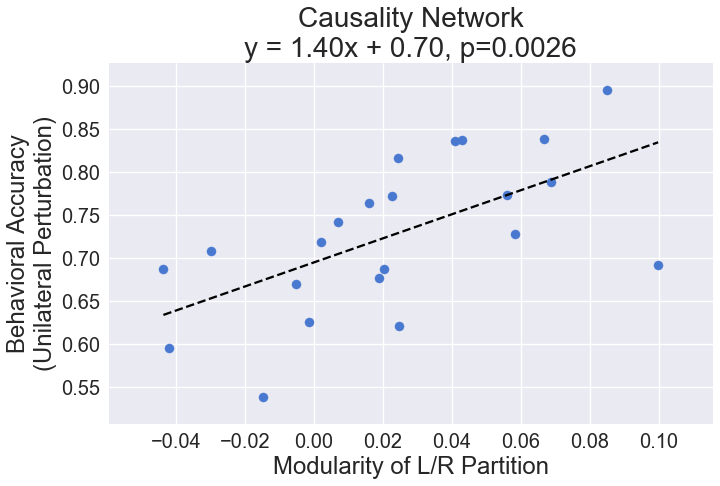

In [25]:
ylabel = 'Behavioral Accuracy\n(Unilateral Perturbation)'
savename = 'modularity-robustness/causality-unilateral-behaviorpred.png'
plot_fit(x, y1, ylabel, savename)


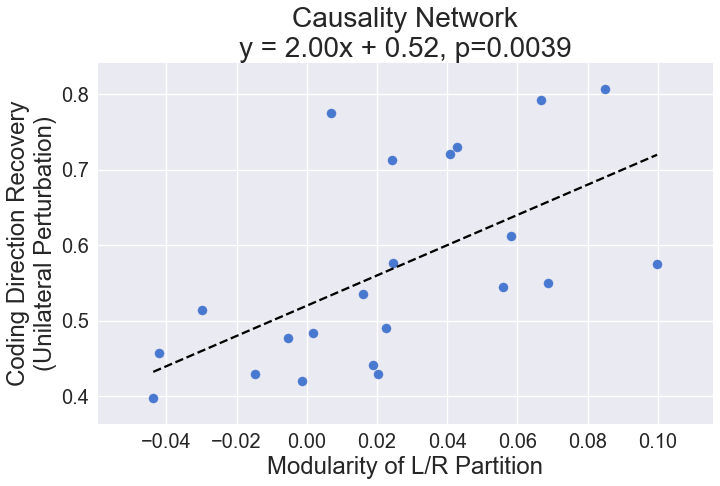

In [28]:
ylabel = 'Coding Direction Recovery\n(Unilateral Perturbation)'
savename = 'modularity-robustness/causality-unilateral-cdrecov.png'
plot_fit(x, y2, ylabel, savename)


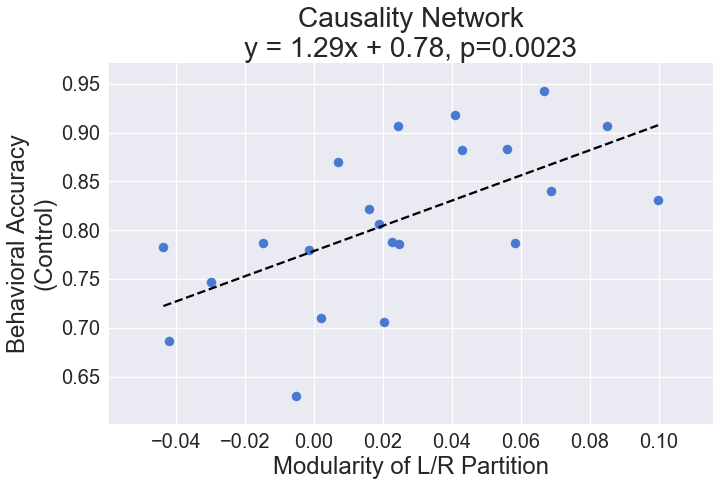

In [27]:
ylabel = 'Behavioral Accuracy\n(Control)'
savename = 'modularity-robustness/causality-control-behaviorpred.png'
plot_fit(x, y3, ylabel, savename)